In [308]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import random
import math
import pickle
import unicodedata

# import ast as ast
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tqdm import tqdm
from datetime import datetime, timedelta, date
#from dtaidistance import dtw
# from multiprocessing import Pool

In [309]:
# Set random seed
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [310]:
import warnings
warnings.filterwarnings('ignore')

In [311]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [312]:
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

len(eventID_all), len(sids_all)

(4203, 15506)

In [ ]:
# 사고 필터링
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]
len(filtered_ID)

4077

In [329]:
target_all = []
for eventID in tqdm(filtered_ID):
    try:
        # with open('/media/usr/WORKING/Naver_Congestion/Pattern_Matching_paperwork/Pattern_Matching_dtw/feature_extraction/target/{}'.format(eventID), 'rb') as f:
        with open('/media/usr/SSD/jiin/naver/Duration Estimation Thesis/feature_extraction/target/{}'.format(eventID), 'rb') as f:
            out = pickle.load(f)
    except:
        continue
        
    if out != None:
        out = [eventID] + out
        target_all.append(out)

100%|██████████| 4077/4077 [00:04<00:00, 860.11it/s] 


In [330]:
target_all = pd.DataFrame(target_all, columns=['eventID', 'speed_drop', 'congestion_score', 'cascading_event', 'congestion_start_idx', 'congestion_duration'])
filtered_ID_list = target_all[target_all.cascading_event==True].eventID.values

In [331]:
len(filtered_ID_list)

849

In [332]:
accident_info_all = []
for eventID in filtered_ID_list:
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    accident_info_all.append(accident_info[0])
accident_all = pd.DataFrame(accident_info_all)

In [336]:
accident_all

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
80,3674056,2020-09-16 10:53:16,2020-09-16 10:31:00,2020-09-16 11:01:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 도봉로 수유치과의원 에서 수유사거리 방향 3차로 고장 차량 주의운전,[1080005204],127.023848,37.632308,1080005204
68,3674448,2020-09-16 13:33:00,2020-09-16 13:31:00,2020-09-16 13:51:00,NaT,NaT,tbs 교통방송,ACCIDENT,강변북로 (일산 → 구리) 동작대교 조금 못 간 저점 2차로 승용차끼리 추돌사고로 정체,[1020000101],126.979425,37.516094,1020000101
73,3674530,2020-09-16 15:39:20,2020-09-16 15:29:00,2020-09-16 15:59:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 화랑로 과기원후문 에서 월곡시장 방향 3차로 고장 차량 주의운전,[1070046900],127.043284,37.603680,1070046900
77,3674610,2020-09-16 16:21:00,2020-09-16 16:13:00,2020-09-16 16:43:00,NaT,NaT,경기도 교통정보센터,ACCIDENT,"[사고] 강변북로 (구리방향) 난지IC → 성산대교 2차로 통제, 사고",[1130004304],126.890628,37.560333,1130004304
75,3674755,2020-09-16 20:21:19,2020-09-16 19:56:00,2020-09-16 20:26:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 화랑로 화랑대사거리 에서 화랑대역 방향 4차로 교통사고,[1100009100],127.086716,37.621437,1100009100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,3803336,2021-02-28 09:49:00,2021-02-28 09:46:00,2021-02-28 10:06:00,NaT,NaT,tbs 교통방송,ACCIDENT,"올림픽대로 하남방면 (한강대교 → 동작대교) 3차로 승용차,화물차 추돌사고로 정체",[1190000101],126.965809,37.509549,1190000101
38,3803337,2021-02-28 11:28:00,2021-02-28 11:27:00,2021-02-28 11:47:00,NaT,NaT,tbs 교통방송,ACCIDENT,강변북로 일산방면 (양화대교 → 성산대교) 1차로 승용차관련 추돌사고로 정체,[1130002402],126.899607,37.553138,1130002402
34,3803342,2021-02-28 11:28:23,2021-02-28 11:13:00,2021-02-28 11:43:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 경부고속도로 반포IC 에서 서초IC 방향 4차로 고장 차량 주의운전,[1210004100],127.020350,37.498191,1210004100
25,3803349,2021-02-28 11:28:23,2021-02-28 11:23:00,2021-02-28 11:53:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 강변북로 양화대교 에서 성산대교 방향 1차로 교통사고 승용차 관련. 후미 ...,[1130002401],126.901521,37.551829,1130002401


In [439]:
accident_all.to_csv('datasets/data/accident_all.csv')

In [470]:
accident_all['sids'].value_counts()

[1210005301]    20
[1030001902]    19
[1220005401]    13
[1210003000]    13
[1130052300]    11
                ..
[1130019202]     1
[2210066900]     1
[1120013402]     1
[1100005401]     1
[1040020100]     1
Name: sids, Length: 489, dtype: int64

In [472]:
accident_all = pd.read_csv('datasets/data/accident_all.csv', index_col=0)
accident_all

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
80,3674056,2020-09-16 10:53:16,2020-09-16 10:31:00,2020-09-16 11:01:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 도봉로 수유치과의원 에서 수유사거리 방향 3차로 고장 차량 주의운전,[1080005204],127.023848,37.632308,1080005204
68,3674448,2020-09-16 13:33:00,2020-09-16 13:31:00,2020-09-16 13:51:00,NaN,NaN,tbs 교통방송,ACCIDENT,강변북로 (일산 → 구리) 동작대교 조금 못 간 저점 2차로 승용차끼리 추돌사고로 정체,[1020000101],126.979425,37.516094,1020000101
73,3674530,2020-09-16 15:39:20,2020-09-16 15:29:00,2020-09-16 15:59:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 화랑로 과기원후문 에서 월곡시장 방향 3차로 고장 차량 주의운전,[1070046900],127.043284,37.603680,1070046900
77,3674610,2020-09-16 16:21:00,2020-09-16 16:13:00,2020-09-16 16:43:00,NaN,NaN,경기도 교통정보센터,ACCIDENT,"[사고] 강변북로 (구리방향) 난지IC → 성산대교 2차로 통제, 사고",[1130004304],126.890628,37.560333,1130004304
75,3674755,2020-09-16 20:21:19,2020-09-16 19:56:00,2020-09-16 20:26:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 화랑로 화랑대사거리 에서 화랑대역 방향 4차로 교통사고,[1100009100],127.086716,37.621437,1100009100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,3803336,2021-02-28 09:49:00,2021-02-28 09:46:00,2021-02-28 10:06:00,NaN,NaN,tbs 교통방송,ACCIDENT,"올림픽대로 하남방면 (한강대교 → 동작대교) 3차로 승용차,화물차 추돌사고로 정체",[1190000101],126.965809,37.509549,1190000101
38,3803337,2021-02-28 11:28:00,2021-02-28 11:27:00,2021-02-28 11:47:00,NaN,NaN,tbs 교통방송,ACCIDENT,강변북로 일산방면 (양화대교 → 성산대교) 1차로 승용차관련 추돌사고로 정체,[1130002402],126.899607,37.553138,1130002402
34,3803342,2021-02-28 11:28:23,2021-02-28 11:13:00,2021-02-28 11:43:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 경부고속도로 반포IC 에서 서초IC 방향 4차로 고장 차량 주의운전,[1210004100],127.020350,37.498191,1210004100
25,3803349,2021-02-28 11:28:23,2021-02-28 11:23:00,2021-02-28 11:53:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 강변북로 양화대교 에서 성산대교 방향 1차로 교통사고 승용차 관련. 후미 ...,[1130002401],126.901521,37.551829,1130002401


In [473]:
# accident_all['accident_sid'] = accident_all['sids'].apply(lambda s: s[0])
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == 1030001902]
accident_case


,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
43,3676787,2020-09-18 13:40:21,2020-09-18 13:23:00,2020-09-18 13:53:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 동부간선도로 성동교 에서 응봉교 방향 3차로 교통사고 주의운전,[1030001902],127.040537,37.551421,1030001902
107,3696850,2020-10-13 13:59:00,2020-10-13 13:58:00,2020-10-13 14:18:00,NaN,NaN,tbs 교통방송,ACCIDENT,[사고] 동부간선도로 (의정부 → 성수대교) 응봉교부근 3차로 추돌사고 처리작업으로 서행,[1030001902],127.040435,37.551444,1030001902
56,3734939,2020-11-22 14:11:00,2020-11-22 14:09:00,2020-11-22 14:29:00,NaN,NaN,tbs 교통방송,ACCIDENT,동부간선도로 (의정부 → 성수대교) 응봉교부근 4차로 승용차끼리 추돌사고로 또 다른...,[1030001902],127.035929,37.547913,1030001902
75,3747858,2020-12-05 11:31:00,2020-12-05 11:30:00,2020-12-05 11:50:00,NaN,NaN,tbs 교통방송,ACCIDENT,동부간선도로 (의정부 → 성수대교) 응봉교부근 3차로 승용차끼리 추돌사고 처리작업으...,[1030001902],127.036857,37.548634,1030001902
73,3747861,2020-12-05 11:41:26,2020-12-05 11:28:00,2020-12-05 11:58:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 동부간선도로 응봉교 에서 용비교 방향 3차로 교통사고 주의운전 서울청,[1030001902],127.034802,37.546882,1030001902
62,3754433,2020-12-12 12:09:00,2020-12-12 12:07:00,2020-12-12 12:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,동부간선도로 (의정부 → 성수대교) 응봉교부근 1차로 승용차관련 추돌사고 처리작업으...,[1030001902],127.036087,37.547985,1030001902
2,3754936,2020-12-13 13:41:00,2020-12-13 13:38:00,2020-12-13 13:58:00,NaN,NaN,tbs 교통방송,ACCIDENT,동부간선도로 (의정부 → 성수대교) 응봉교 조금 지난 지점 4차로 승용차끼리 추돌사...,[1030001902],127.035918,37.547823,1030001902
48,3755878,2020-12-14 16:07:00,2020-12-14 16:06:00,2020-12-14 16:26:00,NaN,NaN,tbs 교통방송,ACCIDENT,동부간선도로 (의정부 → 성수대교) 응봉교부근 4차로 승용차관련 추돌사고로 정체,[1030001902],127.036325,37.548174,1030001902
44,3755890,2020-12-14 16:12:27,2020-12-14 16:03:00,2020-12-14 16:33:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 동부간선도로 성동교 에서 응봉교 방향 4차로 교통사고 승용차-승용차. 후미...,[1030001902],127.038629,37.550296,1030001902
63,3766065,2020-12-28 14:21:00,2020-12-28 14:18:00,2020-12-28 14:38:00,NaN,NaN,tbs 교통방송,ACCIDENT,"[사고] 동부간선도로 (의정부 → 성수대교) 응봉교부근 2차로 승용차,화물차 추돌사...",[1030001902],127.036835,37.548521,1030001902


## Profile Extraction

In [ ]:
def profile_extraction(speed_all):
    # profile df
    time_index = np.arange(datetime(2020, 10, 1), datetime(2021, 3, 1), timedelta(minutes=5)).astype(datetime)
    date_index = np.arange(datetime(2020, 10, 1), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
    profile_df_all = pd.DataFrame(index=time_index, columns=speed_all.columns)

    for date in (date_index):
        profile = []
        index_list = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
        for d in [-28, -21, -14, -7]:
            date_past = date + timedelta(days=d)
            df = speed_all[(speed_all.index >= date_past) & (speed_all.index < date_past+timedelta(days=1))]
            ## speed_all_df의 하루 스피드 데이터가 1440이 아닐때, nan값으로 채우기
            if df.shape[0] != 288:
                print('length error')
                past_index_list = np.arange(date_past, date_past+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
                past_df = pd.DataFrame(index = past_index_list, columns = speed_all.columns)
                pd.concat([df, past_df], axis=1).iloc[:, :len(speed_all.columns)]
            profile.append(df.values)
            
        ## 4주 profile data 평균
        if len(profile) > 0:
            profile_mean = np.nanmean(profile, axis=0)
            profile_df_all.loc[index_list, :] = profile_mean

    return profile_df_all

In [ ]:
## 일주일 단위 profile 구하기
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

## Incident Case

In [ ]:
from networks_pyg.GCN import *
from torch_geometric.utils.convert import from_networkx
import torch.nn.functional as F

In [452]:
target_sid = 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId

In [343]:
    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]
    # speed_list = np.sort([f for f in os.listdir(os.path.join(data_path, 'speeds', eventID)) if f[-3:] == 'pkl'])

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']
    path_inflow = test['path_inflow']
    path_outflow = test['path_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
#     scaler = StandardScaler() 
#     arr_scaled = scaler.fit_transform(speed_all) 
#     df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)

    ## profile extraction
#     profile_all = profile_extraction(df_all_norm)
    speed_all, profile_mean, profile_std = profile_extraction2(speed_all)
    
    
    ## profile normalization
    date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
    df_all_norm = speed_all.copy()

    for date in date_index:
        date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
        tmp = speed_all.loc[date_index]
        weekday = date.weekday()
        mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
        std_tmp = profile_std[288*weekday:288*(weekday+1)]

        normalized = (tmp.values - mean_tmp) / std_tmp
        df_all_norm.loc[date_index] = normalized.values

    
    labels = []
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=240)))))
    label_df = pd.DataFrame(list(map(int, (np.sum(labels, axis=0) > 0))), index=df_all_norm.index, columns=['label'])

In [344]:
label_df.value_counts()

label
0        50875
1          965
dtype: int64

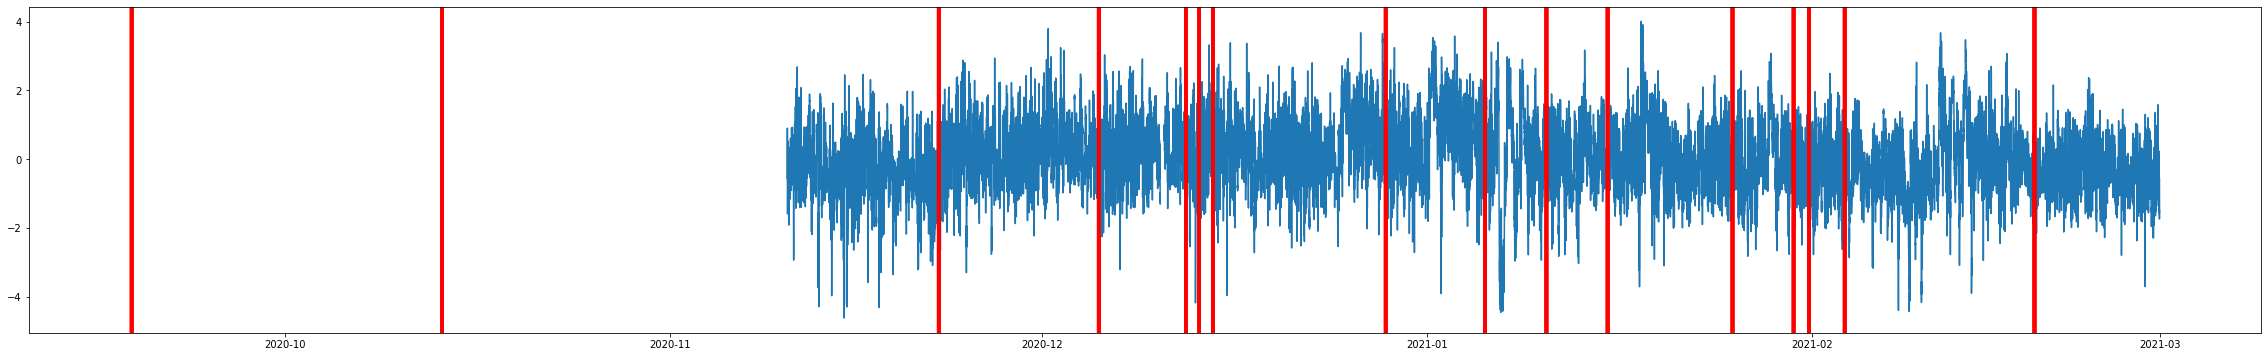

In [345]:
plt.figure(figsize=(40, 6))
temp = label_df.iloc[20000:]
plt.plot(df_all_norm[accident_sid].iloc[20000:])
anomaly_times = label_df[label_df.label == 1].index
for t in anomaly_times: 
    plt.axvline(t, color='red', alpha=0.3)

In [346]:
train_df = df_all_norm[df_all_norm.index < datetime(2020, 11, 1)]
test_df = df_all_norm[df_all_norm.index >= datetime(2020, 11, 1)]
test_label = label_df[label_df.index >= datetime(2020, 11, 1)]
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [347]:
train_g_all = []
for i in tqdm(range(len(train_df)-12)):  
    node_features = train_df.iloc[i:i+12]
    node_features = node_features[list(H.nodes)]
    pyg_graph = from_networkx(H)
    pyg_graph.x = torch.FloatTensor(node_features.T.values)
    pyg_graph.y = torch.tensor([0])
    train_g_all.append(pyg_graph)

100%|██████████| 17268/17268 [00:18<00:00, 937.03it/s] 


In [348]:
test_g_all = []
for i in tqdm(range(len(test_df)-12)):  
    node_features = test_df.iloc[i:i+12]
    node_features = node_features[list(H.nodes)]
    pyg_graph = from_networkx(H)
    pyg_graph.x = torch.FloatTensor(node_features.T.values)
    pyg_graph.y = torch.tensor([test_label.iloc[i+12]])
    test_g_all.append(pyg_graph)

100%|██████████| 34548/34548 [00:35<00:00, 978.43it/s] 


# Model Test

In [349]:
import argparse
import logging
import fire
from torch_geometric.loader import DataLoader

from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score
from optim import Mytrainer

from sklearn.metrics import *

In [350]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.5,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.1,
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=50,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])

In [351]:
args.dataset = 'Accident_profile'
args.module = 'GCN_gc'
checkpoints_path=f'./checkpoints/{args.dataset}+OC-{args.module}+bestcheckpoint.pt'
logging.basicConfig(filename=f"./log/{args.dataset}+OC-{args.module}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
logger=logging.getLogger('OCGNN')

### Train

In [352]:
input_dim = 12
model = init_model(args, input_dim)

Parameter number of GCN_gc Net is: 7072


In [353]:
train_loader = DataLoader(train_g_all, batch_size=64, shuffle=True)
val_loader = DataLoader(test_g_all[], batch_size=64, shuffle=False)
test_loader = DataLoader(test_g_all, batch_size=64, shuffle=False)


model = Mytrainer.train(args, logger, train_loader, val_loader, test_loader, model, checkpoints_path)

new radius =  tensor(0.2346, device='cuda:0', dtype=torch.float64)
Epoch 00000 | Time(s) 1.6183 | Train Loss 29993.6891 | Val Loss 5505.6525 | Val AUROC 0.4224 | 
Epoch 00001 | Time(s) 1.6949 | Train Loss 5505.6525 | Val Loss 5505.9883 | Val AUROC 0.4092 | 
Epoch 00002 | Time(s) 1.6921 | Train Loss 5505.6525 | Val Loss 5505.9795 | Val AUROC 0.4092 | 
Epoch 00003 | Time(s) 1.6896 | Train Loss 5505.6525 | Val Loss 5505.9706 | Val AUROC 0.4092 | 
Epoch 00004 | Time(s) 1.6731 | Train Loss 5505.6525 | Val Loss 5505.9619 | Val AUROC 0.4092 | 
new radius =  tensor(0.0647, device='cuda:0', dtype=torch.float64)
Epoch 00005 | Time(s) 1.6489 | Train Loss 5505.6525 | Val Loss 662.4841 | Val AUROC 0.4092 | 
Epoch 00006 | Time(s) 1.6350 | Train Loss 418.4435 | Val Loss 418.9793 | Val AUROC 0.4548 | 
Epoch 00007 | Time(s) 1.6282 | Train Loss 418.4435 | Val Loss 418.6960 | Val AUROC 0.4546 | 
Epoch 00008 | Time(s) 1.6357 | Train Loss 418.4435 | Val Loss 418.6276 | Val AUROC 0.4544 | 
Epoch 00009 | Tim

RuntimeError: Error(s) in loading state_dict for GCN_gc:
	Missing key(s) in state_dict: "layers.0.bias", "layers.0.lin.weight", "layers.1.bias", "layers.1.lin.weight", "layers.2.bias", "layers.2.lin.weight". 
	Unexpected key(s) in state_dict: "model", "data_center", "radius", "epoch". 

In [354]:
model.load_state_dict(torch.load(checkpoints_path)['model'])
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']

In [355]:
model, data_center, radius

(GCN_gc(
   (layers): ModuleList(
     (0): GCNConv(12, 64)
     (1): GCNConv(64, 64)
     (2): GCNConv(64, 32)
   )
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 tensor([-0.0023,  0.0010,  0.0053,  0.0045, -0.0068, -0.0046, -0.0010, -0.0090,
          0.0090, -0.0041, -0.0052, -0.0024,  0.0105,  0.0019,  0.0078,  0.0038,
          0.0163,  0.0074, -0.0027, -0.0024, -0.0046, -0.0010, -0.0114,  0.0022,
          0.0049,  0.0023, -0.0010, -0.0032,  0.0091, -0.0018, -0.0010,  0.0026],
        device='cuda:0'),
 tensor(0.0082, device='cuda:0', dtype=torch.float64))

In [419]:
out_all, dist_all, score_all = [], [], []
for g in tqdm(test_g_all):
    output = model(g.cuda())
    out_all.append(output.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_all.append(dist.cpu().detach().numpy()[0])
    score_all.append(score.cpu().detach().numpy()[0])

100%|██████████| 34548/34548 [00:50<00:00, 686.13it/s]


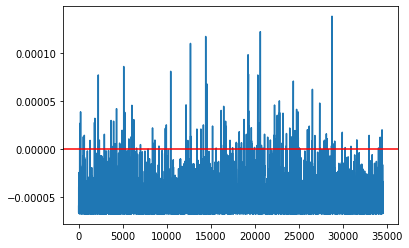

In [420]:
plt.plot(score_all)
plt.axhline(0, color='red')

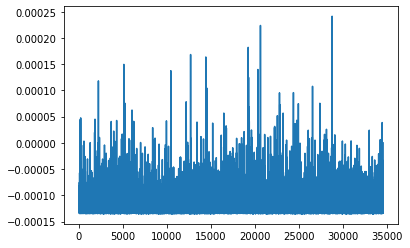

In [433]:
def Cumulative(lists, window=12):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[x-window:x]) for x in range(window, length)]
    return cu_list + [0]*window

plt.plot(Cumulative(score_all, window=2))
cum_score = Cumulative(score_all, window=2)

In [434]:
true = test_label.iloc[:-12].values
pred = list(map(int, [s>0 for s in score_all]))
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33703
           1       0.07      0.02      0.03       845

    accuracy                           0.97     34548
   macro avg       0.52      0.51      0.51     34548
weighted avg       0.95      0.97      0.96     34548



In [435]:
pred_adjust = adjust_predictions(pred, true)
print(classification_report(true, pred_adjust))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33703
           1       0.57      0.43      0.49       845

    accuracy                           0.98     34548
   macro avg       0.78      0.71      0.74     34548
weighted avg       0.98      0.98      0.98     34548



In [436]:
true = test_label.iloc[:-12].values
pred = list(map(int, [s>0 for s in cum_score]))
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33703
           1       0.06      0.02      0.03       845

    accuracy                           0.97     34548
   macro avg       0.52      0.51      0.51     34548
weighted avg       0.95      0.97      0.96     34548



In [437]:
pred_adjust = adjust_predictions(pred, true)
print(classification_report(true, pred_adjust))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33703
           1       0.62      0.43      0.51       845

    accuracy                           0.98     34548
   macro avg       0.80      0.71      0.75     34548
weighted avg       0.98      0.98      0.98     34548



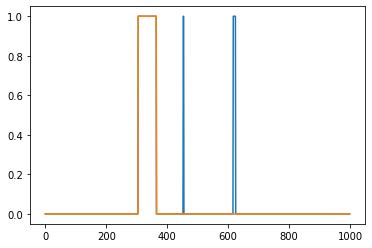

In [438]:
plt.plot(pred[20000:21000])
plt.plot(true[20000:21000])

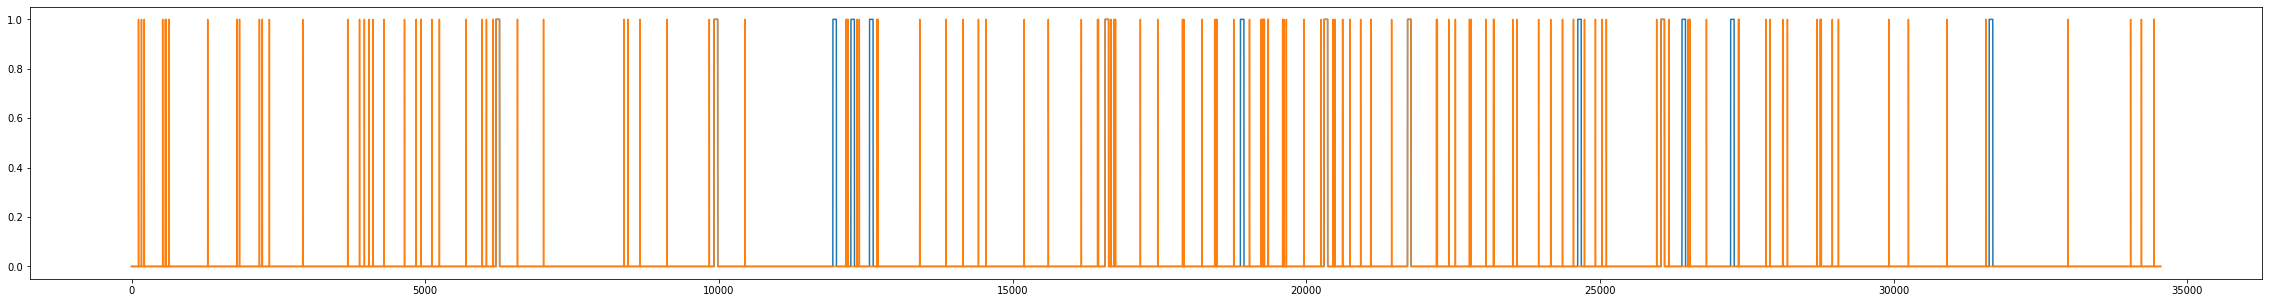

In [377]:
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(pred)

In [375]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              predictions[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      predictions[i] = 1
      
  return predictions

AUC score =  0.7102252762426816
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33703
           1       0.57      0.43      0.49       845

    accuracy                           0.98     34548
   macro avg       0.78      0.71      0.74     34548
weighted avg       0.98      0.98      0.98     34548



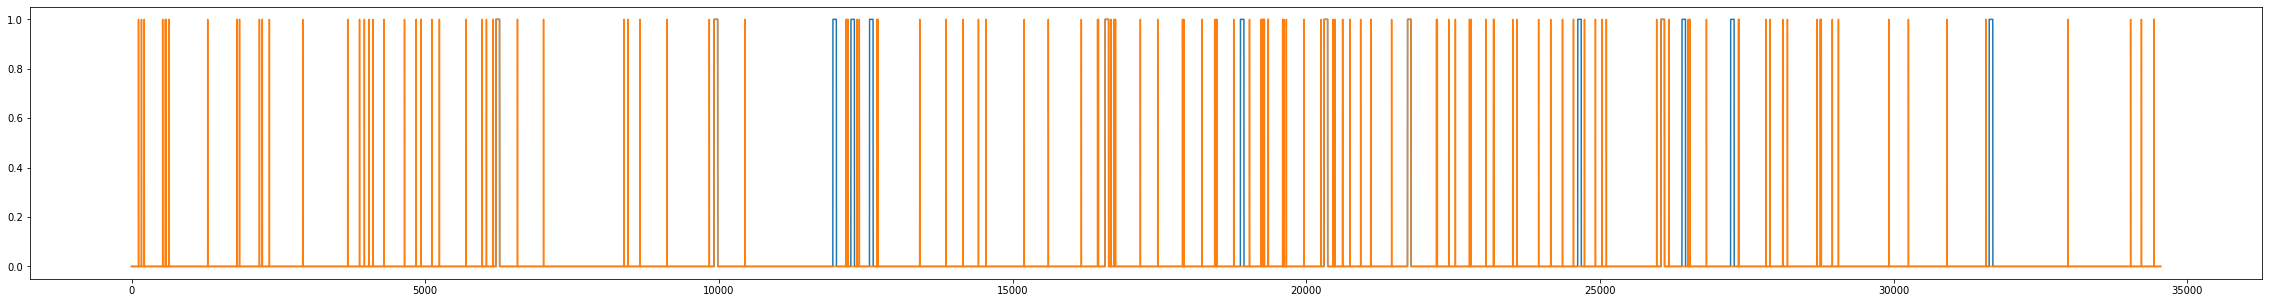

In [379]:
pred_adjust = adjust_predictions(pred, true)
plt.figure(figsize=(40, 5))
plt.plot(true)
plt.plot(pred_adjust)
print('AUC score = ', roc_auc_score(true, pred_adjust))
print(classification_report(true, pred_adjust))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f11b94ba940>
Traceback (most recent call last):
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/jiin/anaconda3/envs/traffic/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


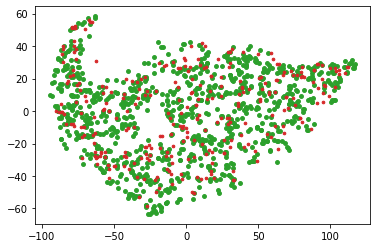

In [378]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_all = tsne.fit_transform(np.concatenate(out_all)[10000:20000])

normal = np.where(true[10000:20000] == 0)
abnormal = np.where(true[10000:20000] == 1)

normal_tsne = tsne_all[normal[0]]
abnormal_tsne = tsne_all[abnormal[0]]
# for i in range(len(normal_tsne)):
for i in range(1000):
    plt.scatter(normal_tsne[i, 0], normal_tsne[i,1], color='tab:green', s=15)
for i in range(len(abnormal_tsne)):
    plt.scatter(abnormal_tsne[i, 0], abnormal_tsne[i,1], color='tab:red', s=7)

# plt.xlim(-0.005, 0.005)
# plt.ylim(-0.005, 0.005)
plt.show()